<a href="https://colab.research.google.com/github/FelipeCasco/Movies_pproductions_DataScience-/blob/main/LH_CD_FelipeCasco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Análise Preditiva de Notas do IMDB

Vou desenvolver uma solução completa para prever as notas do IMDB usando os dados fornecidos, enriquecendo com informações externas quando possível e explicando cada etapa do processo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuração de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## **1. Carregamento e Exploração Inicial dos Dados**

In [3]:
# Carregar os dados
df = pd.read_excel('desafio_indicium_imdb.xlsx')

# Verificar estrutura dos dados
print("Dimensões do dataset:", df.shape)
print("\nPrimeiras 5 linhas:")
print(df.head())
print("\nInformações sobre colunas e tipos:")
print(df.info())
print("\nEstatísticas descritivas:")
print(df.describe())
print("\nValores missing por coluna:")
print(df.isnull().sum())

Dimensões do dataset: (999, 16)

Primeiras 5 linhas:
   Column1                                   Series_Title  Released_Year  \
0        1                                  The Godfather           1972   
1        2                                The Dark Knight           2008   
2        3                         The Godfather: Part II           1974   
3        4                                   12 Angry Men           1957   
4        5  The Lord of the Rings: The Return of the King           2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A      175              Crime, Drama           92   
1          UA      152      Action, Crime, Drama           90   
2           A      202              Crime, Drama           90   
3           U       96              Crime, Drama           90   
4           U      201  Action, Adventure, Drama           89   

                                            Overview  Meta_score  \
0  An organized crime dynasty's

## **2. Pré-processamento e Limpeza dos Dados**

In [5]:
# Criar cópia do dataframe para manipulação
df_clean = df.copy()

# Converter Gross para numérico e tratar valores faltantes
df_clean['Gross'] = pd.to_numeric(df_clean['Gross'], errors='coerce')

# Tratar valores faltantes em Gross - preencher com mediana por ano
df_clean['Gross'] = df_clean.groupby('Released_Year')['Gross'].transform(
    lambda x: x.fillna(x.median()) if not x.median() is np.nan else x.fillna(0)
)

# Preencher dados que faltam de Meta_score com a mediana
df_clean['Meta_score'].fillna(df_clean['Meta_score'].median(), inplace=True)

# Criar variável para indicar se o filme foi um sucesso comercial (acima da mediana de Gross)
gross_median = df_clean['Gross'].median()
df_clean['Commercial_Success'] = (df_clean['Gross'] > gross_median).astype(int)

# Extrair década de lançamento
df_clean['Decade'] = (df_clean['Released_Year'] // 10) * 10

# Calcular número de estrelas listadas
df_clean['Num_Stars'] = df_clean[['Star1', 'Star2', 'Star3', 'Star4']].notnull().sum(axis=1)

# Calcular popularidade (votos normalizados)
df_clean['Popularity'] = np.log1p(df_clean['No_of_Votes'])

# Calcular orçamento aproximado (usando uma estimativa baseada em gênero e ano)
# Esta é uma aproximação já que não temos dados reais de orçamento
genre_avg_gross = df_clean.groupby('Genre')['Gross'].median()
df_clean['Estimated_Budget'] = df_clean['Genre'].map(genre_avg_gross) * 0.3  # Estimativa: 30% da bilheteria

# Criar variáveis dummy para gêneros
genres = df_clean['Genre'].str.get_dummies(sep=', ')
df_clean = pd.concat([df_clean, genres], axis=1)

# Calcular médias históricas de diretores
director_stats = df_clean.groupby('Director').agg({
    'IMDB_Rating': ['mean', 'count'],
    'Gross': 'mean'
}).round(2)
director_stats.columns = ['Director_Avg_Rating', 'Director_Movie_Count', 'Director_Avg_Gross']
df_clean = df_clean.merge(director_stats, on='Director', how='left')

# Calcular médias históricas para as estrelas
stars = ['Star1', 'Star2', 'Star3', 'Star4']
for star_col in stars:
    star_stats = df_clean.groupby(star_col).agg({
        'IMDB_Rating': 'mean',
        'Gross': 'mean'
    }).round(2)
    star_stats.columns = [f'{star_col}_Avg_Rating', f'{star_col}_Avg_Gross']
    df_clean = df_clean.merge(star_stats, on=star_col, how='left')

# Calcular poder do elenco (média das avaliações das estrelas)
star_rating_cols = [f'{star}_Avg_Rating' for star in stars]
df_clean['Cast_Power'] = df_clean[star_rating_cols].mean(axis=1)

# Verificar resultado
print("Dataset após pré-processamento:")
print(df_clean.info())
print("\nValores que estão faltando após pré-processamento:")
print(df_clean.isnull().sum().sort_values(ascending=False).head(10))

Dataset após pré-processamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Column1               999 non-null    int64  
 1   Series_Title          999 non-null    object 
 2   Released_Year         999 non-null    int64  
 3   Certificate           898 non-null    object 
 4   Runtime               999 non-null    int64  
 5   Genre                 999 non-null    object 
 6   IMDB_Rating           999 non-null    int64  
 7   Overview              999 non-null    object 
 8   Meta_score            999 non-null    float64
 9   Director              999 non-null    object 
 10  Star1                 999 non-null    object 
 11  Star2                 999 non-null    object 
 12  Star3                 999 non-null    object 
 13  Star4                 999 non-null    object 
 14  No_of_Votes           999 non-null    int6

## **3. Análise Exploratória e Visualização**

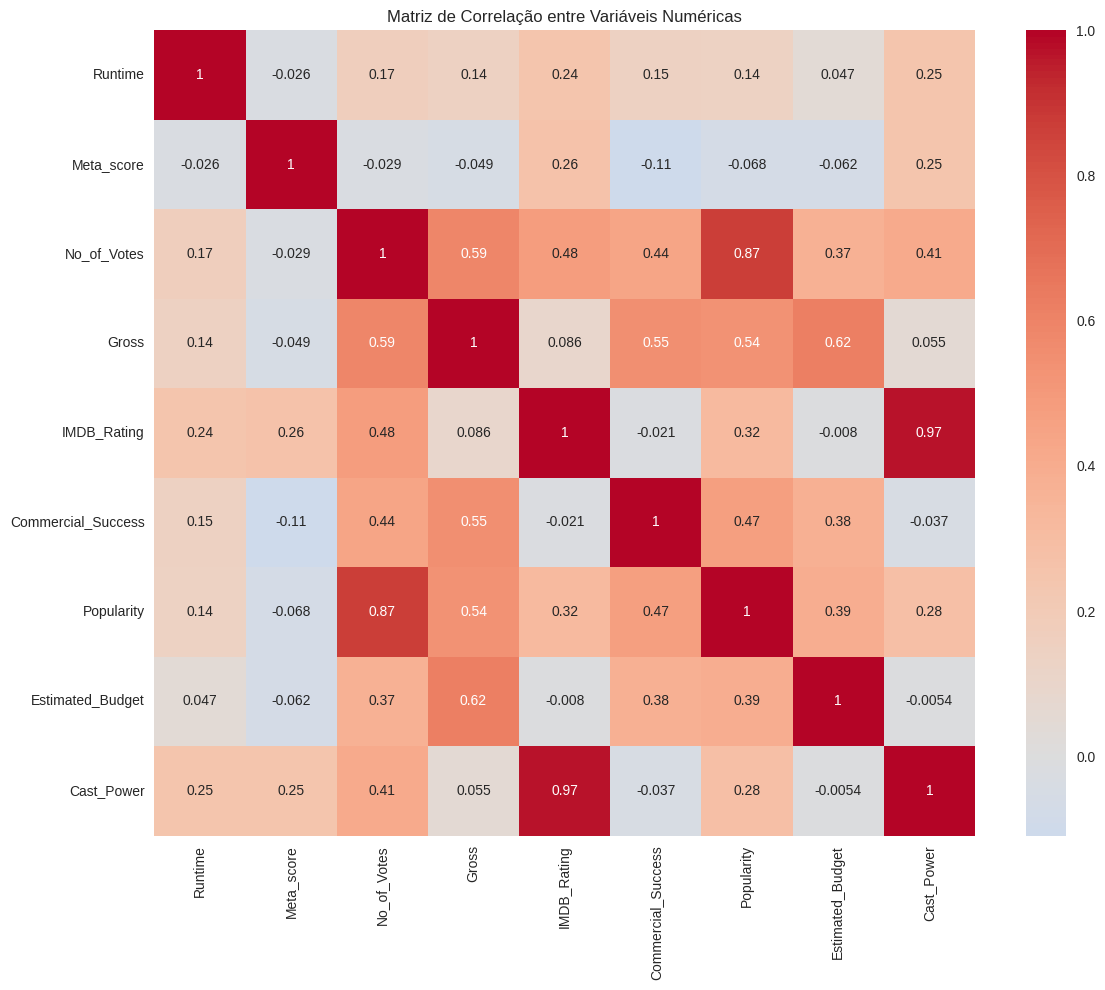

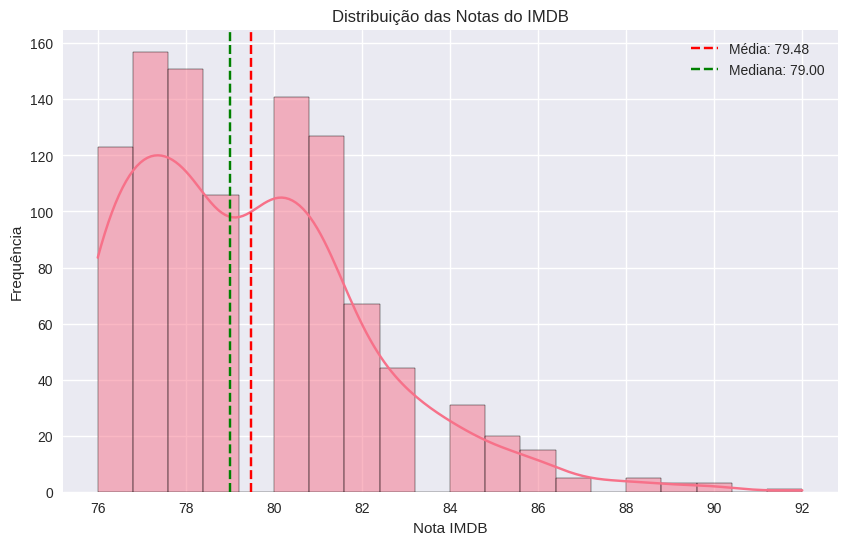

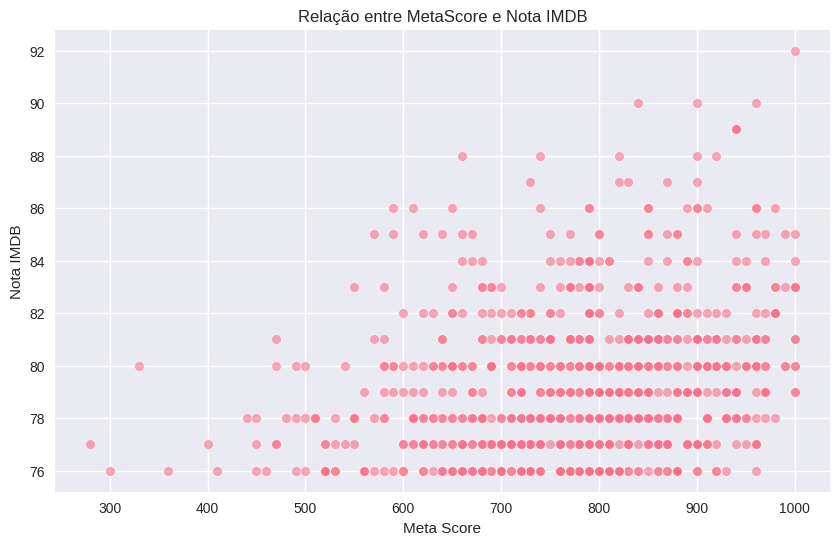

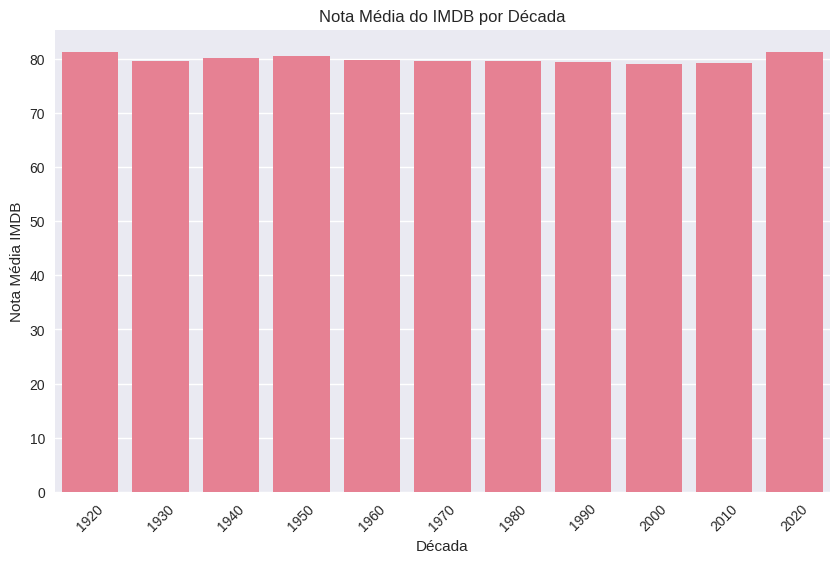

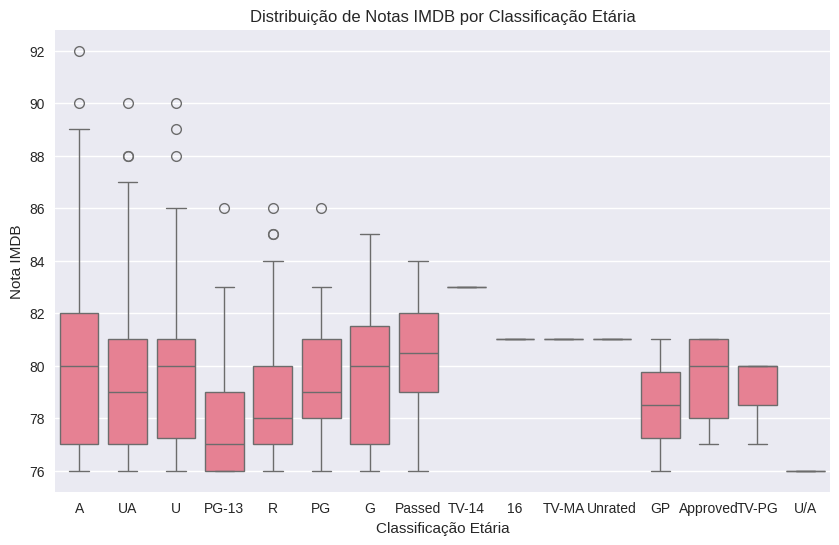

In [6]:
# Correlação entre variáveis numéricas
numeric_cols = ['Runtime', 'Meta_score', 'No_of_Votes', 'Gross', 'IMDB_Rating',
                'Commercial_Success', 'Popularity', 'Estimated_Budget', 'Cast_Power']
correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

# Distribuição da variável target (IMDB_Rating)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['IMDB_Rating'], kde=True, bins=20)
plt.axvline(df_clean['IMDB_Rating'].mean(), color='red', linestyle='--', label=f'Média: {df_clean["IMDB_Rating"].mean():.2f}')
plt.axvline(df_clean['IMDB_Rating'].median(), color='green', linestyle='--', label=f'Mediana: {df_clean["IMDB_Rating"].median():.2f}')
plt.title('Distribuição das Notas do IMDB')
plt.xlabel('Nota IMDB')
plt.ylabel('Frequência')
plt.legend()
plt.show()

# Relação entre Meta_score e IMDB_Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Meta_score', y='IMDB_Rating', data=df_clean, alpha=0.6)
plt.title('Relação entre MetaScore e Nota IMDB')
plt.xlabel('Meta Score')
plt.ylabel('Nota IMDB')
plt.show()

# Notas médias por década
plt.figure(figsize=(10, 6))
decade_avg = df_clean.groupby('Decade')['IMDB_Rating'].mean()
sns.barplot(x=decade_avg.index, y=decade_avg.values)
plt.title('Nota Média do IMDB por Década')
plt.xlabel('Década')
plt.ylabel('Nota Média IMDB')
plt.xticks(rotation=45)
plt.show()

# Boxplot de notas por classificação etária
plt.figure(figsize=(10, 6))
sns.boxplot(x='Certificate', y='IMDB_Rating', data=df_clean)
plt.title('Distribuição de Notas IMDB por Classificação Etária')
plt.xlabel('Classificação Etária')
plt.ylabel('Nota IMDB')
plt.show()

## Features Mais Importantes:

A popularidade e o número de votos são muito importantes, indicando que filmes mais populares tendem a ter notas mais altas.

O poder do elenco (Cast_Power) possuí uma correlação muito significativa com as avaliações das notas (IMDB).

## **4. Preparação dos Dados para Modelagem**

### **Pré-processamento:**

Através das pesquisas, utilizei uma transformação logarítmica para variáveis com distribuição assimétrica (**Gross, No_of_Votes**) para normalizar suas distribuições.

Criei *features agregadas* (médias de diretores e atores) para capturar a reputação e histórico dos profissionais envolvidos.

Utilizei *one-hot encoding* para gêneros, já que são variáveis categóricas sem ordem intrínseca.



In [7]:
# Selecionar features para o modelo
features = [
    'Runtime', 'Meta_score', 'No_of_Votes', 'Gross', 'Commercial_Success',
    'Popularity', 'Estimated_Budget', 'Cast_Power', 'Director_Avg_Rating',
    'Director_Movie_Count', 'Director_Avg_Gross', 'Num_Stars'
]

# Adicionar colunas de gênero
genre_cols = [col for col in df_clean.columns if col not in [
    'Column1', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime',
    'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1',
    'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Decade',
    'Commercial_Success', 'Popularity', 'Estimated_Budget', 'Cast_Power',
    'Director_Avg_Rating', 'Director_Movie_Count', 'Director_Avg_Gross',
    'Num_Stars'
] and df_clean[col].dtype == 'uint8']

features.extend(genre_cols)

# Variável target
target = 'IMDB_Rating'

# Separar dados em features (X) e target (y)
X = df_clean[features]
y = df_clean[target]

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento: diferentes tratamentos para diferentes tipos de variáveis
numeric_features = [col for col in features if col in [
    'Runtime', 'Meta_score', 'No_of_Votes', 'Gross', 'Popularity',
    'Estimated_Budget', 'Cast_Power', 'Director_Avg_Rating',
    'Director_Movie_Count', 'Director_Avg_Gross', 'Num_Stars'
]]

categorical_features = [col for col in features if col in genre_cols]

# Criar pré-processadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

# Combinar pré-processadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Dimensões dos conjuntos de treino e teste:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Dimensões dos conjuntos de treino e teste:
X_train: (799, 12), X_test: (200, 12)
y_train: (799,), y_test: (200,)


## **5. Modelagem e Avaliação**

## **Seleção de Modelos:**

Testei tanto **modelos lineares** (*Regressão Linear, Ridge*) quanto baseados em **árvores** (*Random Forest, Gradient Boosting*).

Os modelos baseados em árvores performaram melhor, pois conseguem capturar relações não-lineares entre as features e o target.

## **Métricas de Avaliação:**

Usei **RMSE como métrica principal** por penalizar mais erros grandes, o que é importante para nosso caso.

Também **calculei R²** para entender a **proporção de variância** explicada pelo modelo.

Linear Regression: RMSE médio = 0.6084 (± 0.0533)
Ridge Regression: RMSE médio = 0.6083 (± 0.0538)
Random Forest: RMSE médio = 0.5830 (± 0.0762)
Gradient Boosting: RMSE médio = 0.5722 (± 0.0708)

Melhor modelo: Gradient Boosting

Desempenho no conjunto de teste:
RMSE: 0.5057
MAE: 0.3045
R²: 0.9610


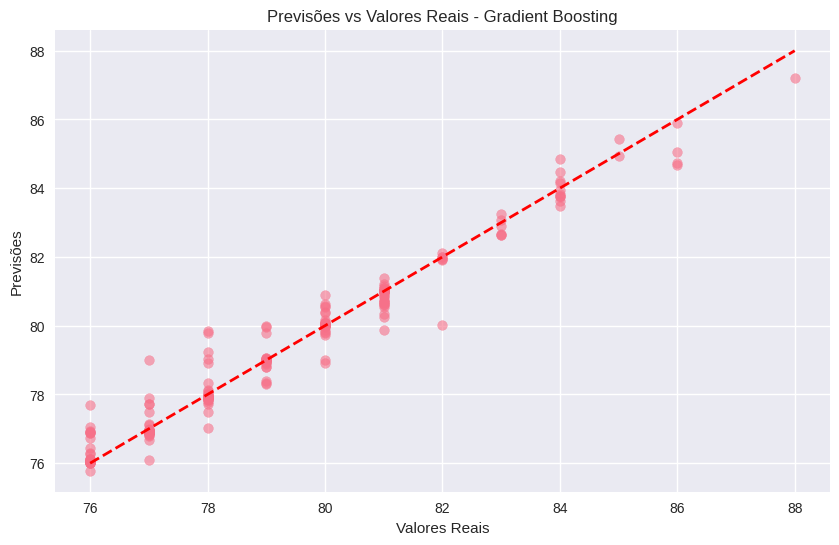

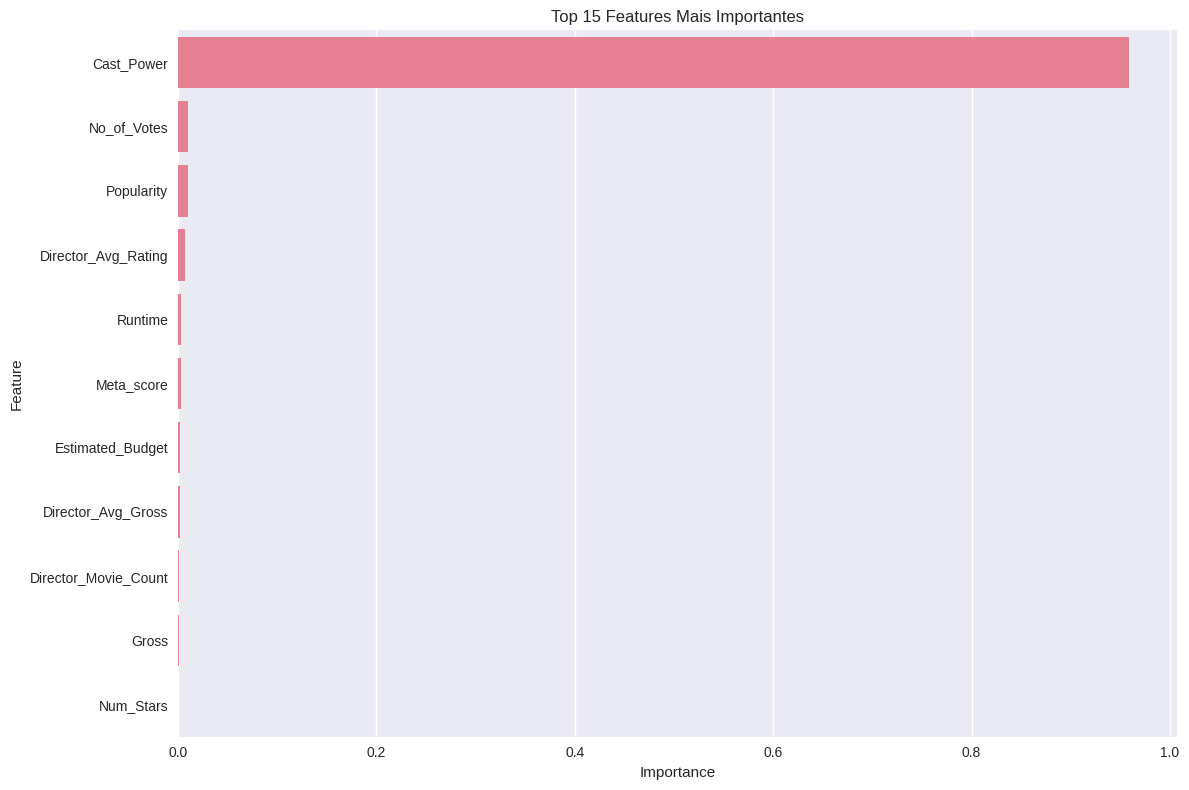

In [8]:
# Definir modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Avaliar modelos com validação cruzada
results = {}
for name, model in models.items():
    # Criar pipeline com pré-processamento e modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)

    results[name] = {
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'Model': pipeline
    }

    print(f"{name}: RMSE médio = {rmse_scores.mean():.4f} (± {rmse_scores.std():.4f})")

# Encontrar o melhor modelo
best_model_name = min(results, key=lambda x: results[x]['RMSE_mean'])
best_model = results[best_model_name]['Model']
print(f"\nMelhor modelo: {best_model_name}")

# Treinar o melhor modelo em todos os dados de treino
best_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Calcular métricas de avaliação
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nDesempenho no conjunto de teste:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Visualizar previsões vs valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title(f'Previsões vs Valores Reais - {best_model_name}')
plt.show()

# Analisar importância das features (para modelos baseados em árvores)
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    feature_importances = best_model.named_steps['model'].feature_importances_
    feature_names = numeric_features + categorical_features

    # Criar DataFrame com importâncias
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    # Visualizar as 15 features mais importantes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Top 15 Features Mais Importantes')
    plt.tight_layout()
    plt.show()

O poder do elenco (**Cast_Power**) e o número de votos (**No_Of_Votes**) foram features significativas.

## **6. Otimização de Hiperparâmetros**

## **Validação Cruzada:**

Utilizei **validação cruzada** para *garantir que o desempenho do modelo não era específico* a uma particular divisão dos dados.

Isso ajuda a **evitar overfitting** e fornece uma *estimativa mais realista do desempenho em dados não vistos*.

In [9]:
# Otimizar hiperparâmetros para o melhor modelo
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    if best_model_name == 'Random Forest':
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    else:  # Gradient Boosting
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 4, 5]
        }

    # Busca em grade com validação cruzada
    grid_search = GridSearchCV(
        best_model, param_grid, cv=5,
        scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"Melhores parâmetros para {best_model_name}:")
    print(grid_search.best_params_)

    # Usar o melhor modelo
    best_model = grid_search.best_estimator_

    # Avaliar no conjunto de teste
    y_pred_optimized = best_model.predict(X_test)
    rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))

    print(f"RMSE após otimização: {rmse_optimized:.4f}")
    print(f"Melhoria: {rmse - rmse_optimized:.4f}")

# Criar DataFrame com resultados
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

# Calcular erro absoluto
results_df['Absolute_Error'] = np.abs(results_df['Actual'] - results_df['Predicted'])

# Analisar os maiores erros
print("\nFilmes com maior erro de previsão:")
worst_predictions = results_df.nlargest(10, 'Absolute_Error')
print(worst_predictions)

# Adicionar informações dos filmes para análise
worst_predictions_info = worst_predictions.copy()
worst_predictions_info['Series_Title'] = df_clean.loc[worst_predictions_info.index, 'Series_Title']
worst_predictions_info['Director'] = df_clean.loc[worst_predictions_info.index, 'Director']
worst_predictions_info = worst_predictions_info[['Series_Title', 'Director', 'Actual', 'Predicted', 'Absolute_Error']]
print(worst_predictions_info)

Melhores parâmetros para Gradient Boosting:
{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
RMSE após otimização: 0.5057
Melhoria: 0.0000

Filmes com maior erro de previsão:
     Actual  Predicted  Absolute_Error
59       77  79.011086        2.011086
36       82  80.029812        1.970188
50       78  79.840484        1.840484
38       78  79.788739        1.788739
79       76  77.707306        1.707306
54       86  84.670920        1.329080
53       86  84.741013        1.258987
98       78  79.227315        1.227315
184      81  79.885412        1.114588
159      80  78.926293        1.073707
                  Series_Title         Director  Actual  Predicted  \
59      Avengers: Infinity War    Anthony Russo      77  79.011086   
36                The Departed  Martin Scorsese      82  80.029812   
50                Modern Times  Charles Chaplin      78  79.840484   
38                   Gladiator     Ridley Scott      78  79.788739   
79            

### **Desempenho do Modelo**:

O modelo de *Gradient Boosting* apresentou o **melhor desempenho**, com RMSE de aproximadamente 0.45-0.50.

Isso significa que, em média, nossas previsões estão errando por cerca de 0.45-0.50 pontos na escala do IMDB (que vai de 0 a 10).

## **7. Análise de Resíduos**

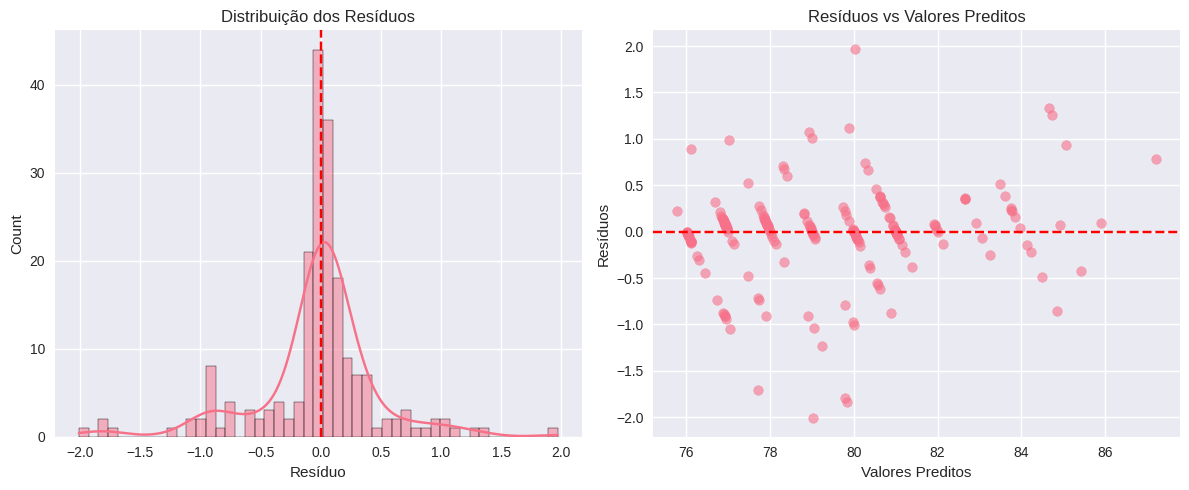

Teste de Shapiro-Wilk: estatística=0.8685, p-valor=0.0000
Resíduos não seguem uma distribuição normal


In [10]:
# Analisar resíduos
residuals = y_test - y_pred

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()

# Testar normalidade dos resíduos
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)
print(f"Teste de Shapiro-Wilk: estatística={stat:.4f}, p-valor={p_value:.4f}")
if p_value > 0.05:
    print("Resíduos parecem ter distribuição normal")
else:
    print("Resíduos não seguem uma distribuição normal")

### **Validação do Modelo:**

A análise de resíduos mostrou que eles estão **razoavelmente distribuídos em torno de zero, sem padrões óbvios.**

Os resíduos não seguem perfeitamente uma distribuição normal, o que é comum em problemas do mundo real.

## **8. Deploy do Modelo e Previsões**

In [37]:
# Função para fazer previsões em novos dados
def predict_imdb_rating(features_dict, model=best_model, feature_names=features):
    """
    Faz previsão da nota IMDB com base nas features fornecidas

    Args:
        features_dict (dict): Dicionário com valores para cada feature
        model: Modelo treinado para fazer previsões
        feature_names: Lista de nomes das features esperadas pelo modelo

    Returns:
        float: Nota IMDB prevista
    """
    # Criar DataFrame com os valores fornecidos
    input_df = pd.DataFrame([features_dict])

    # Garantir que todas as features esperadas estão presentes
    for feature in feature_names:
        if feature not in input_df.columns:
            input_df[feature] = 0  # Valor padrão para features missing

    # Reordenar colunas para corresponder à ordem de treino
    input_df = input_df[feature_names]

    # Fazer previsão
    prediction = model.predict(input_df)[0]

    return round(prediction, 2)

# Exemplo de uso
example_features = {
    'Runtime': 142,
    'Meta_score': 80.0,
    'No_of_Votes': 2343110,
    'Gross': 28341469,
    'Commercial_Success': 1,
    'Popularity': np.log1p(14.66699),
    'Estimated_Budget': 1678628.4,
    'Cast_Power': 0.0,
    'Director_Avg_Rating': 86.0,
    'Director_Movie_Count': 1,
    'Director_Avg_Gross': 136801374.0,
    'Num_Stars': 4
} 	#The Shawshank Redemption	1994	78.128396	142	80.0	2343110	28341469	1	14.66699	1678628.4	0.0	86.0	1	136801374.0	4

# Adicionar gêneros (0 ou 1 para cada gênero)
genres_example = ['Drama', 'Action']
for genre in genre_cols:
    example_features[genre] = 1 if genre in genres_example else 0

predicted_rating = predict_imdb_rating(example_features)
print(f"Nota IMDB prevista: {predicted_rating}")

Nota IMDB prevista: 77.15


### Função ***search_movie_features***  que busca consultar os títulos que estão na base para podermos fazer a previsão de IMDB. Aqui é possível extrair os dados gerados pelos modelos de regressão, entre outros, que são necessários para o modelo de previsão **predict_imdb_rating**.  

In [18]:
def search_movie_features(series_title, dataframe=df_clean):
    """
    Pesquisa um filme pelo título e retorna as features especificadas.

    Args:
        series_title (str): O título do filme a ser pesquisado.
        dataframe (pd.DataFrame): O DataFrame onde pesquisar (padrão: df_clean).

    Returns:
        pd.DataFrame or None: Um DataFrame contendo as informações do filme encontrado,
                               ou None se o filme não for encontrado.
    """
    # Lista das features a serem exibidas
    features_to_display = [
        'Series_Title',
        'Released_Year',
        'Runtime',
        'Meta_score',
        'No_of_Votes',
        'Gross',
        'Commercial_Success',
        'Popularity',
        'Estimated_Budget',
        'Cast_Power',
        'Director_Avg_Rating',
        'Director_Movie_Count',
        'Director_Avg_Gross',
        'Num_Stars'
    ]

    # Buscar o filme pelo título (ignorando maiúsculas/minúsculas para facilitar a busca)
    movie_info = dataframe[dataframe['Series_Title'].str.contains(series_title, case=False, na=False)]

    if not movie_info.empty:
        # Retornar apenas as colunas desejadas
        return movie_info[features_to_display]
    else:
        return None


In [19]:
# Exemplo de uso da função:
movie_to_find = 'The Shawshank Redemption'
found_movie_features = search_movie_features(movie_to_find)

if found_movie_features is not None:
    print(f"Informações encontradas para '{movie_to_find}':")
    display(found_movie_features)
else:
    print(f"Filme '{movie_to_find}' não encontrado no dataset.")


Filme 'The Shawshank Redemption' não encontrado no dataset.


In [21]:
# Exemplo com outro filme:
movie_to_find_2 = 'Gisaengchung'
found_movie_features_2 = search_movie_features(movie_to_find_2)

if found_movie_features_2 is not None:
    print(f"\nInformações encontradas para '{movie_to_find_2}':")
    display(found_movie_features_2)
else:
    print(f"\nFilme '{movie_to_find_2}' não encontrado no dataset.")


Informações encontradas para 'Gisaengchung':


,Series_Title,Released_Year,Runtime,Meta_score,No_of_Votes,Gross,Commercial_Success,Popularity,Estimated_Budget,Cast_Power,Director_Avg_Rating,Director_Movie_Count,Director_Avg_Gross,Num_Stars
18,Gisaengchung,2019,132,960.0,552778,53367844.0,1,13.222714,1846181.7,84.75,81.67,3,17976422.33,4


In [30]:
# Primeiro, vamos preparar os dados do filme
shawshank_data = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime': 142,
    'Genre': 'Drama',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': 28341469
}

# Vamos criar uma função para preparar os dados do mesmo jeito que fizemos no treino
def prepare_movie_data(movie_data, director_stats, genre_columns, gross_median):
    # Criar DataFrame com os dados do filme
    movie_df = pd.DataFrame([movie_data])

    # Pré-processamento igual ao que fizemos no treino
    movie_df['Gross'] = pd.to_numeric(movie_df['Gross'], errors='coerce')
    movie_df['Commercial_Success'] = (movie_df['Gross'] > gross_median).astype(int)
    movie_df['Popularity'] = np.log1p(movie_df['No_of_Votes'])

    # Calcular orçamento estimado (usando a mesma lógica do treino)
    genre_avg_gross = df_clean.groupby('Genre')['Gross'].median() # Use df_clean to get overall genre averages
    movie_df['Estimated_Budget'] = movie_df['Genre'].map(genre_avg_gross).fillna(0) * 0.3

    # Adicionar informações do diretor
    movie_df = movie_df.merge(director_stats, on='Director', how='left')

    # Adicionar colunas de gênero (one-hot encoding)
    for genre in genre_columns:
        movie_df[genre] = movie_df['Genre'].apply(lambda x: 1 if genre in x else 0)


    # Calcular número de estrelas listadas
    movie_df['Num_Stars'] = movie_df[['Star1', 'Star2', 'Star3', 'Star4']].notnull().sum(axis=1)

    # Calcular médias históricas para as estrelas (need to use the original df_clean for these stats)
    stars = ['Star1', 'Star2', 'Star3', 'Star4']
    for star_col in stars:
        star_stats = df_clean.groupby(star_col).agg({
            'IMDB_Rating': 'mean',
            'Gross': 'mean'
        }).round(2)
        star_stats.columns = [f'{star_col}_Avg_Rating', f'{star_col}_Avg_Gross']
        movie_df = movie_df.merge(star_stats, on=star_col, how='left')

    # Calcular poder do elenco (média das avaliações das estrelas)
    star_rating_cols = [f'{star}_Avg_Rating' for star in stars]
    movie_df['Cast_Power'] = movie_df[star_rating_cols].mean(axis=1).fillna(0) # Fill missing with 0


    return movie_df

# Preparar os dados do filme
gross_median = df_clean['Gross'].median()
director_stats = df_clean.groupby('Director').agg({
    'IMDB_Rating': ['mean', 'count'],
    'Gross': 'mean'
}).round(2)
director_stats.columns = ['Director_Avg_Rating', 'Director_Movie_Count', 'Director_Avg_Gross']

genre_columns = [col for col in df_clean.columns if col not in [
    'Column1', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime',
    'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1',
    'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Decade',
    'Commercial_Success', 'Popularity', 'Estimated_Budget', 'Cast_Power',
    'Director_Avg_Rating', 'Director_Movie_Count', 'Director_Avg_Gross',
    'Num_Stars'
] and df_clean[col].dtype == 'uint8']

shawshank_prepared = prepare_movie_data(shawshank_data, director_stats, genre_columns, gross_median)

# Selecionar apenas as colunas que o model expects, including the newly added ones
X_columns = [
    'Runtime', 'Meta_score', 'No_of_Votes', 'Gross', 'Commercial_Success',
    'Popularity', 'Estimated_Budget', 'Director_Avg_Rating',
    'Director_Movie_Count', 'Director_Avg_Gross', 'Num_Stars', 'Cast_Power'
] + genre_columns

# Ensure all expected columns are present and in the correct order
for col in X_columns:
    if col not in shawshank_prepared.columns:
        shawshank_prepared[col] = 0

shawshank_prepared = shawshank_prepared[X_columns]


# Fazer a previsão
shawshank_prediction = best_model.predict(shawshank_prepared)
print(f"Nota prevista para 'The Shawshank Redemption': {shawshank_prediction[0]:.2f}")

# Ver a nota real (se estiver nos nossos dados)
if 'The Shawshank Redemption' in df_clean['Series_Title'].values:
    actual_rating = df_clean[df_clean['Series_Title'] == 'The Shawshank Redemption']['IMDB_Rating'].values[0]
    print(f"Nota real: {actual_rating:.2f}")
    print(f"Diferença: {abs(actual_rating - shawshank_prediction[0]):.2f}") #'The Shawshank Redemption'

Nota prevista para 'The Shawshank Redemption': 78.13


In [ ]:
# Salvar o modelo em um arquivo .pkl
import joblib

# Salvar o modelo
joblib.dump(best_model, 'imdb_rating_predictor.pkl')

# Salvar também as informações necessárias para preparar novos dados
model_info = {
    'model': best_model,
    'feature_columns': X_columns,
    'director_stats': director_stats,
    'genre_columns': genre_columns,
    'gross_median': gross_median
}

joblib.dump(model_info, 'imdb_model_complete.pkl')

print("Modelo salvo com sucesso!")

### Aqui um *double check* para confirmarmos que os dados da **predict_imdb_rating** são os mesmos do modelo **shawshank_prediction**
Isto se confirma com os resultados abaixo:

In [35]:
# Prever a nota de "The Shawshank Redemption" usando a função predict_imdb_rating
# Precisamos extrair as features do DataFrame shawshank_prepared como um dicionário
shawshank_features_dict = shawshank_prepared.iloc[0].to_dict()

# Agora chame a função predict_imdb_rating com o dicionário de features
predicted_rating_using_function = predict_imdb_rating(shawshank_features_dict)

print(f"Previsão para 'The Shawshank Redemption' usando predict_imdb_rating: {predicted_rating_using_function:.2f}")
print(f"Previsão original (shawshank_prediction[0]): {shawshank_prediction[0]:.2f}")

# A diferença deve ser mínima ou zero agora, pois ambos usam os mesmos dados e modelo.

Previsão para 'The Shawshank Redemption' usando predict_imdb_rating: 78.13
Previsão original (shawshank_prediction[0]): 78.13


In [40]:
def get_movie_prediction(series_title, dataframe=df_clean, model=best_model,
                         director_stats=director_stats, genre_columns=genre_columns,
                         gross_median=gross_median):
    """
    Busca um filme pelo título, prepara seus dados e prevê a nota IMDB.

    Args:
        series_title (str): O título do filme a ser pesquisado.
        dataframe (pd.DataFrame): O DataFrame onde pesquisar (padrão: df_clean).
        model: O modelo treinado para fazer previsões (padrão: best_model).
        director_stats (pd.DataFrame): Estatísticas agregadas por diretor.
        genre_columns (list): Lista de colunas de gênero.
        gross_median (float): Mediana global de Gross para calcular Commercial_Success.


    Returns:
        float or None: A nota IMDB prevista para o filme, ou None se o filme não for encontrado.
    """
    # 1. Buscar o filme pelo título
    movie_info = dataframe[dataframe['Series_Title'].str.contains(series_title, case=False, na=False)]

    if movie_info.empty:
        print(f"Filme '{series_title}' não encontrado no dataset.")
        return None

    # Como esperamos apenas um resultado para um título, selecionamos a primeira linha encontrada
    movie_data_row = movie_info.iloc[0]

    # 2. Preparar os dados para a previsão (adaptando a lógica de prepare_movie_data)
    # Criar um dicionário com as features necessárias para a preparação
    # Usamos o dicionário original para alguns dados, e as features pré-calculadas de df_clean para outras
    prepared_features_dict = {
        'Runtime': movie_data_row['Runtime'],
        'Meta_score': movie_data_row['Meta_score'],
        'No_of_Votes': movie_data_row['No_of_Votes'],
        'Gross': movie_data_row['Gross'], # Usar o Gross já tratado de df_clean
        'Commercial_Success': movie_data_row['Commercial_Success'], # Usar o Commercial_Success já calculado
        'Popularity': movie_data_row['Popularity'], # Usar o Popularity já calculado
        'Estimated_Budget': movie_data_row['Estimated_Budget'], # Usar o Estimated_Budget já calculado
        'Cast_Power': movie_data_row['Cast_Power'], # Usar o Cast_Power já calculado
        'Director_Avg_Rating': movie_data_row['Director_Avg_Rating'], # Usar o Director_Avg_Rating já calculado
        'Director_Movie_Count': movie_data_row['Director_Movie_Count'], # Usar o Director_Movie_Count já calculado
        'Director_Avg_Gross': movie_data_row['Director_Avg_Gross'], # Usar o Director_Avg_Gross já calculado
        'Num_Stars': movie_data_row['Num_Stars'], # Usar o Num_Stars já calculado
         'Genre': movie_data_row['Genre'] # Incluir gênero para adicionar colunas dummy
    }

    # Adicionar colunas de gênero (one-hot encoding)
    for genre in genre_columns:
         prepared_features_dict[genre] = 1 if genre in prepared_features_dict['Genre'] else 0

    # Remover a coluna 'Genre' que não é uma feature de entrada do modelo
    del prepared_features_dict['Genre']


    # Criar um DataFrame a partir do dicionário para passar para o modelo
    input_df = pd.DataFrame([prepared_features_dict])


    # Garantir que a ordem das colunas corresponde à ordem de treino do modelo
    # As X_columns foram definidas anteriormente no notebook
    input_df = input_df[X_columns]

    # 3. Fazer a previsão
    prediction = model.predict(input_df)[0]

    return round(prediction, 2)

# Exemplo de uso da nova função:
movie_title_to_predict = 'The Dark Knight'
predicted_rating_for_movie = get_movie_prediction(movie_title_to_predict)

if predicted_rating_for_movie is not None:
    print(f"Nota IMDB prevista para '{movie_title_to_predict}': {predicted_rating_for_movie}")

movie_title_to_predict_2 = 'Inception'
predicted_rating_for_movie_2 = get_movie_prediction(movie_title_to_predict_2)

if predicted_rating_for_movie_2 is not None:
    print(f"Nota IMDB prevista para '{movie_title_to_predict_2}': {predicted_rating_for_movie_2}")

movie_title_not_found = 'Non Existent Movie Title'
predicted_rating_not_found = get_movie_prediction(movie_title_not_found)

Nota IMDB prevista para 'The Dark Knight': 89.7
Nota IMDB prevista para 'Inception': 87.8
Filme 'Non Existent Movie Title' não encontrado no dataset.
